BINARIZATION

In [ ]:
import cv2
from matplotlib import pyplot as plt
import numpy as no

image = cv2.imread('screens/ikran6.png')[:870, :]
template = cv2.imread('sprites/Alchemist_Sprite.png')

image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)

ret1, th1 = cv2.threshold(image, 191, 255, cv2.THRESH_BINARY)
ret2, th2 = cv2.threshold(template, 191, 255, cv2.THRESH_BINARY)

fig = plt.figure(figsize=(10, 7))
plt.imshow(th1)
plt.show()
fig = plt.figure(figsize=(10, 7))
plt.imshow(th2)
plt.show()

#TM_CCOEFF, TM_CCOEFF_NORMED, TM_CCORR, TM_CCORR_NORMED, TM_SQDIFF, TM_SQDIFF_NORMED
result = cv2.matchTemplate(th1, th2, cv2.TM_CCOEFF_NORMED)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
threshold = 0.7
w, h = template.shape[1], template.shape[0]
print(max_val)
if max_val >= threshold:
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv2.rectangle(image, top_left, bottom_right,
                    color=(0, 255, 0), thickness=2, lineType=cv2.LINE_4)
    fig = plt.figure(figsize=(10, 7))
    plt.imshow(image)
    plt.show()
else:
    print('не нашел')


Перебор методов поиска соответствия на фотке

In [ ]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
original = cv.imread('screens/ikran4.png')[:870, :]
orig = original.copy()
img = cv.imread('screens/ikran4.png')[:870, :]
image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
_, img = ret1,th1 = cv2.threshold(img,50,255,cv2.THRESH_BINARY)
img2 = img.copy()
template = cv.imread('sprites/Alchemist_Sprite.png')
template_gray = cv2.cvtColor(template, cv2.COLOR_RGB2GRAY)
_, template = cv2.threshold(template,50,255,cv2.THRESH_BINARY)
w, h = template.shape[1], template.shape[0]
# All the 3 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR_NORMED','cv.TM_CCORR','cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    original = orig.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    print(f"meth={meth} , min_val={min_val}, max_val={max_val}, min_loc={min_loc}, max_loc={max_loc}")

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = min_loc#max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(original,top_left, bottom_right, 255, 2)
    fig = plt.figure(figsize=(10, 7))
    plt.imshow(original)
    plt.show()

CANNY EDGE

In [ ]:
import cv2
from matplotlib import pyplot as plt
import os

def thresh(img, tmp):
    lst = [i for i in range(1,300+20,10)]
    res = []
    edg = []
    for x in lst:
        edg.append(x)
        edges_image = cv2.Canny(image, x, 200)
        edges_template = cv2.Canny(tmp, x,200)
        result = cv2.matchTemplate(edges_image, edges_template, cv2.TM_CCOEFF_NORMED)
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(result)
        #print(max_val)
        res.append(max_val*100)
        threshold = 0.7
        w, h = template.shape[1], template.shape[0]
        if max_val >= threshold:
            top_left = max_loc
            bottom_right = (top_left[0] + w, top_left[1] + h)
            cv2.rectangle(img, top_left, bottom_right,
                            color=(0, 255, 0), thickness=2, lineType=cv2.LINE_4)
            #cv2.imwrite('screens/record1/results', img)
    plt.plot(edg, res)
    plt.xlabel('x')
    plt.ylabel('%')
    fig = plt.figure(figsize=(10, 7))
    plt.imshow(img)
    plt.show()
    return max_val >= threshold



def start():
    lst = os.listdir('screens/record1')[:100]
    template = os.listdir('sprites')
    count = 0
    for x in lst:
        for i in range(len(template)):
            thresh(cv2.imread(f'screens/record1/{x}', cv2.IMREAD_GRAYSCALE)[400:870, :],
                   cv2.imread(f'sprites/{template[i]}', cv2.IMREAD_GRAYSCALE))


image = cv2.imread('screens/record1/09.11.23_21:20:53.646.png', cv2.IMREAD_GRAYSCALE)[400:870, :]
template = cv2.imread('sprites/Werewolf_Sprite.png', cv2.IMREAD_GRAYSCALE)
thresh(image, template)
#start()

KEYPOINT DETECTION (https://habr.com/ru/companies/joom/articles/445354/)

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import keras

from keras.optimizers import Adam

import os
import numpy as np
import itertools

import cv2
import os
%matplotlib inline

DETECTOR_METHOD_FAST = "fast"
DETECTOR_METHOD_SIFT = "sift"
DETECTOR_METHOD_HARRIS = "harris"

DESCRIPTOR_METHOD_BRIEF = "brief"
DESCRIPTOR_METHOD_SIFT = "sift"

def get_image_description(img, threshold = 75,
                          detector = DETECTOR_METHOD_FAST,
                          descriptor = DESCRIPTOR_METHOD_SIFT,
                          drawDebug = False):
    img_array = image.img_to_array(img)
    img_grayscale = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY).astype(np.uint8)

    if detector == DETECTOR_METHOD_HARRIS:
        keypoints = []
        responses = cv2.cornerHarris(img_grayscale, 2, 3, 0.04)
        for x in (-responses.flatten()).argsort()[:threshold]:
            indices = np.unravel_index(x, responses.shape)
            keypoints.append(cv2.KeyPoint(float(indices[1]), float(indices[0]), 17))
    elif detector == DETECTOR_METHOD_SIFT:
        feat = cv2.xfeatures2d.SIFT_create(threshold)
        keypoints = feat.detect(img_grayscale, None)
    elif detector == DETECTOR_METHOD_FAST:
        feat = cv2.FastFeatureDetector_create(threshold)
        keypoints = feat.detect(img_grayscale, None)
    else:
        raise Exception("Unknown detector")

    if drawDebug:
        img_array_kp = img_array.copy().astype(np.uint8)
        cv2.drawKeypoints(img_array_kp, keypoints, img_array_kp, (0, 255, 0))
        plt.axis('off')
        plt.imshow(img_array_kp)
        plt.show()

    if descriptor == DESCRIPTOR_METHOD_SIFT:
        descriptor = cv2.SIFT_create()
    else:
        descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
    return img_array, descriptor.compute(img_grayscale, keypoints)

def keypoint_match(pic, pattern, pic_desc, pattern_desc, drawDebug = False):
    bf = cv2.BFMatcher()
    matches = bf.match(pattern_desc[1], pic_desc[1])

    if drawDebug:
        plt.figure(figsize=(20, 20))
        plt.axis('off')
        plt.imshow(cv2.drawMatches(pattern.astype(np.uint8), pattern_desc[0], pic.astype(np.uint8), pic_desc[0], matches, 0,
                                   flags=0, matchColor=(0, 255, 0), singlePointColor=(255, 0, 0)).astype(np.uint8))
        plt.show()
    return matches

pattern, pattern_desc = get_image_description(image.load_img("sprites/Werewolf_Sprite.png"), drawDebug = True)
pic, pic_desc = get_image_description(image.load_img("screens/record1/09.11.23_21:20:53.646.png"), drawDebug = True)
matches = keypoint_match(pic, pattern, pic_desc, pattern_desc, True)
for descriptor in [DESCRIPTOR_METHOD_SIFT, DESCRIPTOR_METHOD_BRIEF]:
    pattern, pattern_desc = get_image_description(
        image.load_img("screens/record1/09.11.23_21:20:53.646.png"), 5, detector=DETECTOR_METHOD_FAST, descriptor = descriptor)

    pic, pic_desc = get_image_description(
        image.load_img("screens/record1/09.11.23_21:20:53.646.png"), 5, detector=DETECTOR_METHOD_FAST, descriptor = descriptor)
    # matches = keypoint_match(pic.astype(np.uint8), pattern_with_kp.astype(np.uint8), pic_desc, pattern_desc, True)
    # matches = keypoint_match(pic, pattern, pic_desc, pattern_desc, True)
descriptor = cv2.xfeatures2d.BriefDescriptorExtractor_create()
pattern, pattern_desc = get_image_description(image.load_img("screens/record1/09.11.23_21:20:53.646.png"), threshold=100, detector=DETECTOR_METHOD_HARRIS, drawDebug=True)
pattern, pattern_desc = get_image_description(image.load_img("screens/record1/09.11.23_21:20:53.646.png"), threshold=100, detector=DETECTOR_METHOD_SIFT, drawDebug=True)
pattern, pattern_desc = get_image_description(image.load_img("screens/record1/09.11.23_21:20:53.646.png"), threshold=5, detector=DETECTOR_METHOD_FAST, drawDebug=True)
for detector, t_pattern, t_img in [(DETECTOR_METHOD_HARRIS, 100, 10000), (DETECTOR_METHOD_FAST, 10, 10), (DETECTOR_METHOD_SIFT, 100, 5000)]:
    for img in ["screens/record1/09.11.23_21:20:53.646.png", "screens/record1/09.11.23_21:18:13.664.png", "screens/record1/09.11.23_21:20:58.225.png"]:
        pattern, pattern_desc = get_image_description(image.load_img("screens/record1/09.11.23_21:20:53.646.png"), t_pattern, detector=detector, drawDebug=False)
        pic, pic_desc = get_image_description(image.load_img(img), t_img, detector=detector)
        matches = keypoint_match(pic, pattern, pic_desc, pattern_desc, True)
        plt.show()

CONTOUR DETECTION

In [ ]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np

import keras

from keras.optimizers import Adam

import os
import numpy as np
import itertools

import cv2
import os
%matplotlib inline

def get_edge_map(img, debugDraw = False):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if debugDraw:
        plt.figure(figsize=(20, 10))
        plt.subplot(3, 1, 1)
        plt.axis("off")
        plt.imshow(button_img)

    img_gray = cv2.blur(img_gray, (3, 3))
    edges = cv2.Canny(img_gray, 3, 220)[:, :, np.newaxis] / 255.0
    if debugDraw:
        plt.subplot(3, 1, 2)
        plt.axis("off")
        plt.imshow(edges[:, :, 0])

    edges = cv2.dilate(edges, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    edges = cv2.erode(edges, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)))
    if debugDraw:
        plt.subplot(3, 1, 3)
        plt.axis("off")
        plt.imshow(edges[:, :] > 0)

    return edges

img_f = image.load_img("screens/record1/09.11.23_21:20:53.646.png")
button_img = np.array(image.load_img("sprites/Werewolf_Sprite.png"))
_ = get_edge_map(button_img, True)

from collections import Counter

def get_button_contour(edges, debugDraw = False):
    contours,_ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    shapes = Counter()

    for i, cnt in enumerate(contours):
        area = cv2.contourArea(cnt)
        (x, y, w, h) = cv2.boundingRect(cnt)

        if (w * h * 0.9 < area) & (area > 100):
            shapes[i] = area
            if debugDraw:
                cv2.drawContours(img_f, [cnt], -1, (255, 0, 0), 5)
    if debugDraw:
        cv2.drawContours(img_f, [contours[shapes.most_common(1)[0][0]]], -1, (0, 255, 0), 5)
        plt.imshow(img_f)
    return contours[shapes.most_common(1)[0][0]]

for i, img in enumerate(["screens/record1/09.11.23_21:20:53.646.png", "screens/record1/09.11.23_21:20:53.646.png", "screens/record1/09.11.23_21:20:58.225.png"]):
    plt.figure(figsize=(10, 10))
    plt.axis("off")
    img_f = np.array(image.load_img(img))[:870, :]
    edges = get_edge_map(img_f)
    get_button_contour(edges, True)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from keras.optimizers import Adam
import numpy as np
import cv2
%matplotlib inline

def get_edge(img):
    img_blur = cv2.blur(img, (4,4))
    edges = cv2.Canny(img_blur, 100, 200)
    edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_CROSS, (7,7)))
    return edges
def get_threshold(img):
    _,img = cv2.threshold(img,101, 255, cv2.THRESH_BINARY)
    return img
def get_match(img, tmp):
    w, h = tmp.shape[1], tmp.shape[0]
    res = cv2.matchTemplate(img, tmp, cv2.TM_CCOEFF_NORMED)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    if max_val>=0.7:
        top_left = min_loc#max_loc
        bottom_right = (top_left[0] + w, top_left[1] + h)
        cv.rectangle(img,top_left, bottom_right, 255, 2)
        return img
    else:
        print("не нашел")
        return img



img = cv2.imread('screens/record1/09.11.23_21:20:51.231.png', cv2.IMREAD_GRAYSCALE)
template = cv2.imread('sprites/Frost_Skull_Sprite.png', cv2.IMREAD_GRAYSCALE)
img_thresh = get_threshold(img)
template_thresh = get_threshold(template)
plt.figure(figsize=(10,10))
plt.imshow(img_thresh)
img_edge = get_edge(img_thresh)
template_edge = get_edge(template_thresh)
plt.figure(figsize=(10,10))
plt.imshow(img_edge)
res = get_match(img_edge, template_edge)
plt.figure(figsize=(10,10))
plt.imshow(res)

HOG-DESCRIPTOR

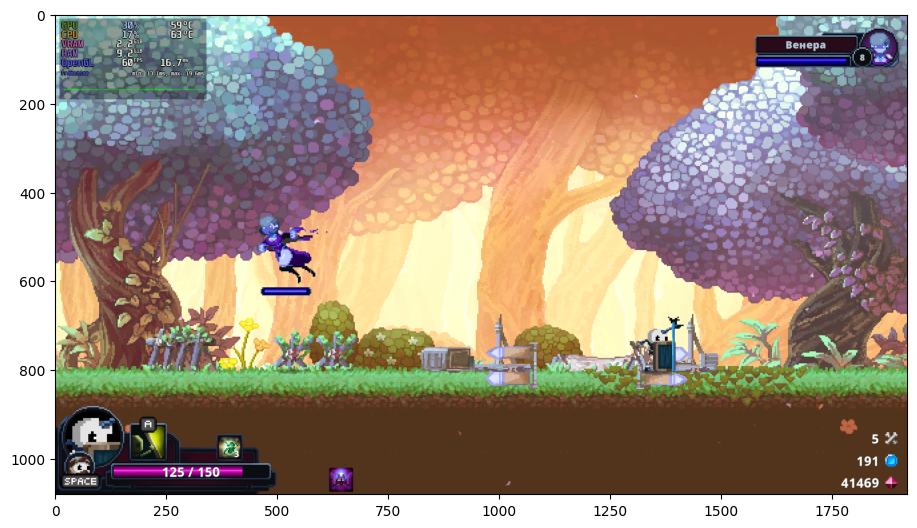

In [19]:
import matplotlib.pyplot as plt
img = cv2.imread('screens/ikran.png')
cv2.imwrite('compress_img1.png', img, [cv2.IMWRITE_PNG_COMPRESSION, 10])
img = cv2.imread('compress_img1.png')
plt.figure(figsize=(11,11))
plt.imshow(img)